In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sklearn
import xgboost as xgb
from xgboost import XGBClassifier 
from xgboost import XGBRegressor 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.stats import uniform, randint
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder 
import pickle
import time

In [3]:
df_train = pd.read_csv('train.csv')

In [4]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


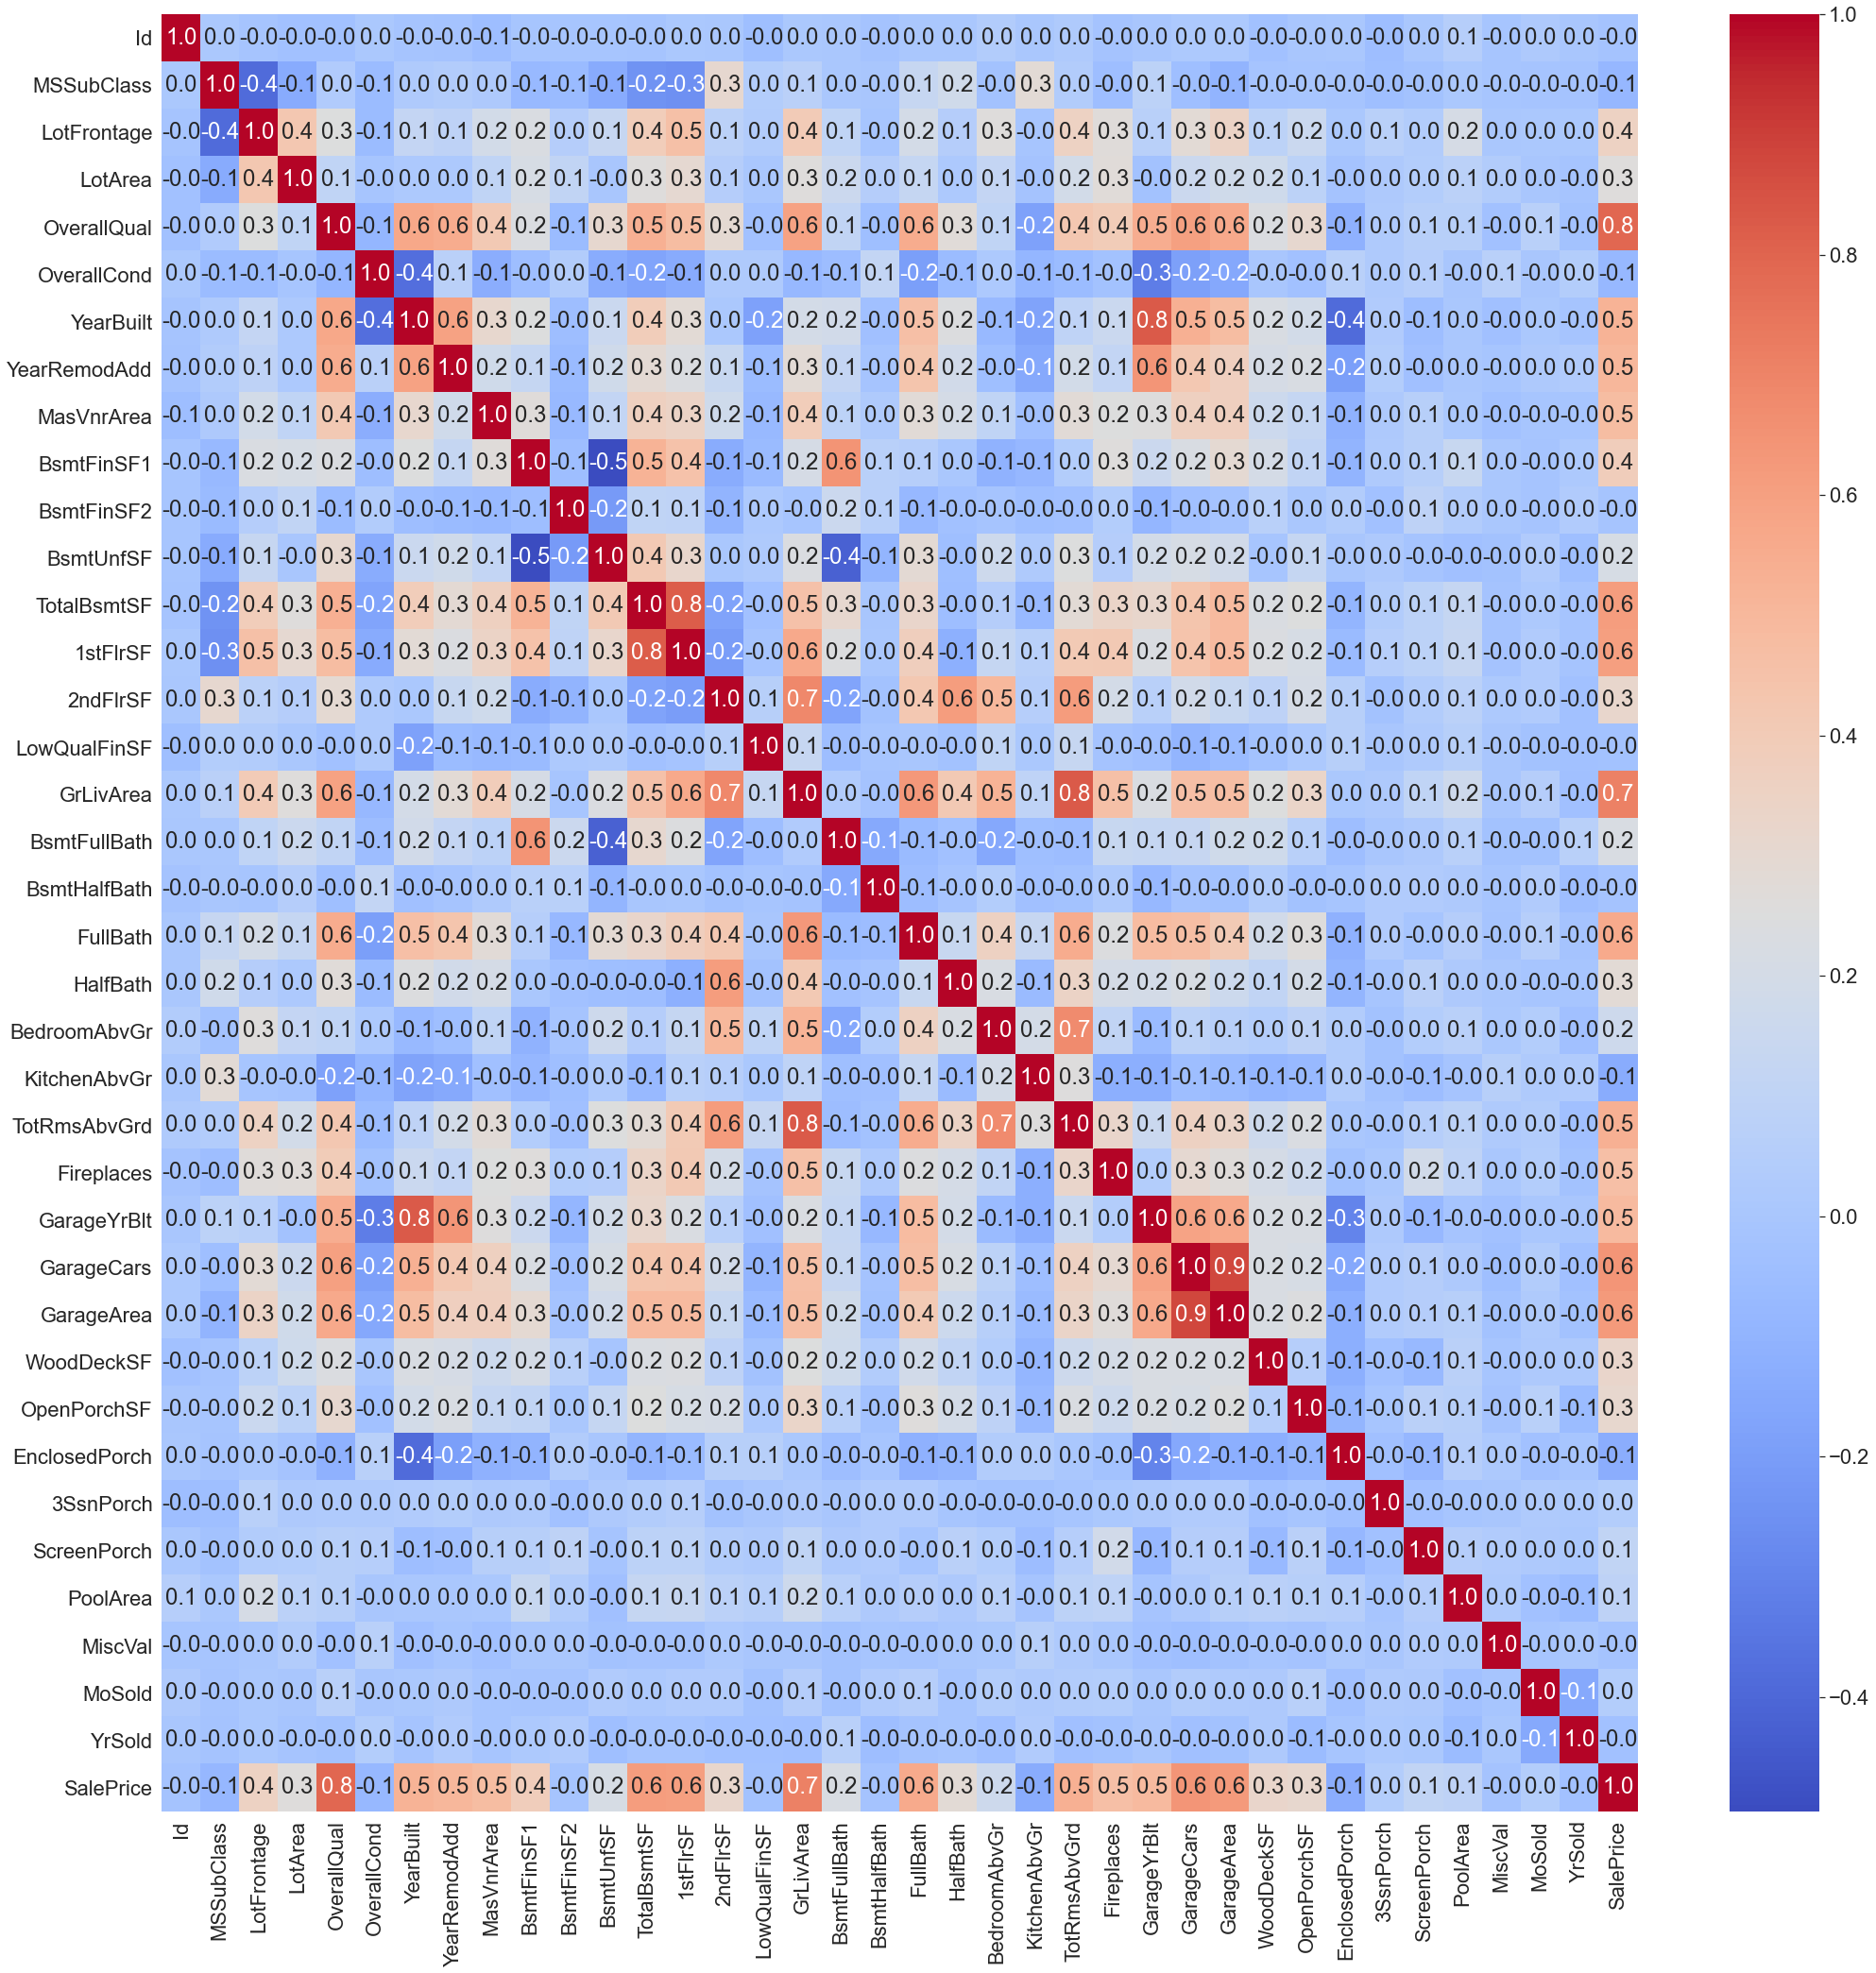

In [5]:
plt.rcParams['figure.figsize']= 35,35
sns.set(font_scale=2)
g = sns.heatmap(df_train.corr(), annot=True, fmt = ".1f", cmap = "coolwarm")


## Scatter plots

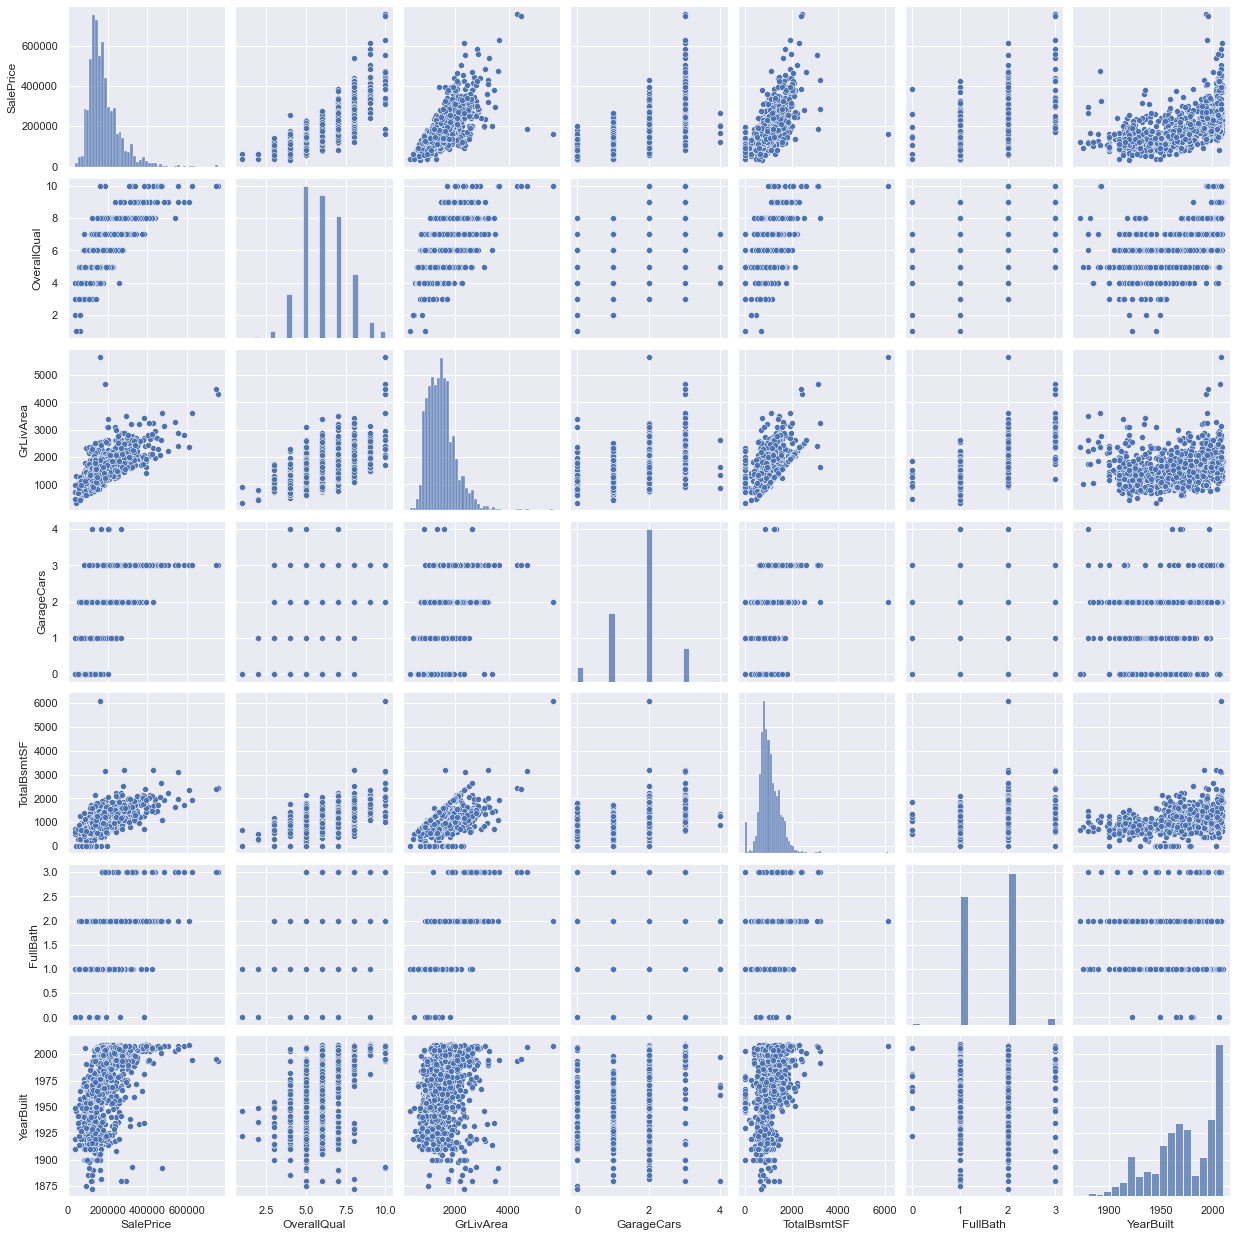

In [6]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], height = 2.5)


## Checking for missing data

In [7]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [8]:
df_train.columns.to_series().groupby(df_train.dtypes).groups

{int64: ['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'], float64: ['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], object: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'Garage

In [9]:
# Drop Ids

In [10]:
df_train.drop('Id', axis=1,inplace=True) 

In [11]:
target = ['SalePrice']

In [12]:
numerical_columns = [ 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
        'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
        'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
        'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
        'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
        'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold','LotFrontage', 'MasVnrArea',
                     'GarageYrBlt']

In [13]:
target_encode_columns = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'Heating', 'HeatingQC', 'Electrical', 'KitchenQual',
        'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
        'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
        'SaleType', 'SaleCondition','Utilities','PavedDrive']


target_encode_df = df_train[target_encode_columns + target].reset_index().drop(columns = 'index', axis = 1)


In [14]:
df_train['HasCentralAir'] = np.where(df_train['CentralAir']=='Y',1,0)
df_train.drop('CentralAir',axis=1,inplace=True)

In [15]:
target_name = target[0]
target_df = pd.DataFrame()
encoding_dict = {}
for embed_col in target_encode_columns:
    val_map = target_encode_df.groupby(embed_col)[target].mean().to_dict()[target_name]
    encoding_dict[embed_col] = val_map
    target_df[embed_col] = target_encode_df[embed_col].map(val_map).values

# # Save encoding dict

In [16]:
with open('encoding_dict.txt', 'w') as file:
    json.dump(encoding_dict, file)

In [17]:
target_df.head()

,MSZoning,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,Utilities,PavedDrive
0,191004.994787,181130.538514,NaN,164754.818378,180183.746758,176938.047529,179956.799566,197965.773333,184495.492063,181169.405536,185763.807377,210051.764045,171483.956179,179803.679219,213732.900971,214432.460317,204691.871910,231633.510246,184034.896256,225230.442040,202688.478964,183632.620900,165652.295908,235413.720096,184694.690287,182021.195378,214914.429150,186825.113193,212116.023891,183429.147059,NaN,202892.656322,202068.869668,187489.836003,187885.735294,NaN,NaN,NaN,173401.836622,175202.219533,180950.95682,186433.973881
1,191004.994787,181130.538514,NaN,164754.818378,180183.746758,177934.574468,179956.799566,238772.727273,142475.481481,181169.405536,185763.807377,175985.477961,171483.956179,179803.679219,149422.177273,149803.172897,156221.891204,144341.313466,184034.896256,149805.714511,202688.478964,183632.620900,257689.805970,161573.068182,184694.690287,182021.195378,214914.429150,186825.113193,139962.511565,183429.147059,205723.488818,202892.656322,202068.869668,187489.836003,187885.735294,NaN,NaN,NaN,173401.836622,175202.219533,180950.95682,186433.973881
2,191004.994787,181130.538514,NaN,206101.665289,180183.746758,176938.047529,179956.799566,197965.773333,184495.492063,181169.405536,185763.807377,210051.764045,171483.956179,179803.679219,213732.900971,214432.460317,204691.871910,231633.510246,184034.896256,225230.442040,202688.478964,183632.620900,192789.657895,235413.720096,184694.690287,182021.195378,214914.429150,186825.113193,212116.023891,183429.147059,205723.488818,202892.656322,202068.869668,187489.836003,187885.735294,NaN,NaN,NaN,173401.836622,175202.219533,180950.95682,186433.973881
3,191004.994787,181130.538514,NaN,206101.665289,180183.746758,181623.425856,179956.799566,210624.725490,184495.492063,181169.405536,185763.807377,210051.764045,171483.956179,179803.679219,149841.645631,161328.947368,156221.891204,144341.313466,184034.896256,132291.075342,140759.818182,213599.907692,165652.295908,161573.068182,184694.690287,182021.195378,156858.871369,186825.113193,212116.023891,183429.147059,226351.415789,134091.162791,142156.423140,187489.836003,187885.735294,NaN,NaN,NaN,173401.836622,146526.623762,180950.95682,186433.973881
4,191004.994787,181130.538514,NaN,206101.665289,180183.746758,177934.574468,179956.799566,335295.317073,184495.492063,181169.405536,185763.807377,210051.764045,171483.956179,179803.679219,213732.900971,214432.460317,204691.871910,231633.510246,184034.896256,225230.442040,202688.478964,183632.620900,206643.420814,235413.720096,184694.690287,182021.195378,214914.429150,186825.113193,212116.023891,183429.147059,205723.488818,202892.656322,202068.869668,187489.836003,187885.735294,NaN,NaN,NaN,173401.836622,175202.219533,180950.95682,186433.973881


In [18]:
df_train_encoding_target_drop = df_train.drop(target_encode_columns, axis = 1).reset_index().drop(columns = 'index', axis = 1)
df_target = pd.concat([df_train_encoding_target_drop, target_df], axis = 1)

In [19]:
df_target.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,HasCentralAir,MSZoning,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,Utilities,PavedDrive
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500,1,191004.994787,181130.538514,NaN,164754.818378,180183.746758,176938.047529,179956.799566,197965.773333,184495.492063,181169.405536,185763.807377,210051.764045,171483.956179,179803.679219,213732.900971,214432.460317,204691.871910,231633.510246,184034.896256,225230.442040,202688.478964,183632.620900,165652.295908,235413.720096,184694.690287,182021.195378,214914.429150,186825.113193,212116.023891,183429.147059,NaN,202892.656322,202068.869668,187489.836003,187885.735294,NaN,NaN,NaN,173401.836622,175202.219533,180950.95682,186433.973881
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500,1,191004.994787,181130.538514,NaN,164754.818378,180183.746758,177934.574468,179956.799566,238772.727273,142475.481481,181169.405536,185763.807377,175985.477961,171483.956179,179803.679219,149422.177273,149803.172897,156221.891204,144341.313466,184034.896256,149805.714511,202688.478964,183632.620900,257689.805970,161573.068182,184694.690287,182021.195378,214914.429150,186825.113193,139962.511565,183429.147059,205723.488818,202892.656322,202068.869668,187489.836003,187885.735294,NaN,NaN,NaN,173401.836622,175202.219533,180950.95682,186433.973881
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500,1,191004.994787,181130.538514,NaN,206101.665289,180183.746758,176938.047529,179956.799566,197965.773333,184495.492063,181169.405536,185763.807377,210051.764045,171483.956179,179803.679219,213732.900971,214432.460317,204691.871910,231633.510246,184034.896256,225230.442040,202688.478964,183632.620900,192789.657895,235413.720096,184694.690287,182021.195378,214914.429150,186825.113193,212116.023891,183429.147059,205723.488818,202892.656322,202068.869668,187489.836003,187885.735294,NaN,NaN,NaN,173401.836622,175202.219533,180950.95682,186433.973881
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000,1,191004.994787,181130.538514,NaN,206101.665289,180183.746758,181623.425856,179956.799566,210624.725490,184495.492063,181169.405536,185763.807377,210051.764045,171483.956179,179803.679219,149841.645631,161328.947368,156221.891204,144341.313466,184034.896256,132291.075342,140759.818182,213599.907692,165652.295908,161573.068182,184694.690287,182021.195378,156858.871369,186825.113193,212116.023891,183429.147059,226351.415789,134091.162791,142156.423140,187489.836003,187885.735294,NaN,NaN,NaN,173401.836622,146526.623762,180950.95682,186433.973881
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000,1,191004.994787,181130.538514,NaN,206101.665289,180183.746758,177934.574468,179956.799566,335295.317073,184495.492063,181169.405536,185763.807377,210051.764045,171483.956179,179803.679219,213732.900971,214432.460317,204691.871910,231633.510246,184034.896256,225230.442040,202688.478964,183632.620900,206643.420814,235413.720096,184694.690287

In [20]:
Y= df_target['SalePrice']
df_target.drop('SalePrice',axis=1,inplace=True)
X= df_target

In [21]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)


In [22]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_test.columns)

In [23]:
num_boost_round = 999

In [24]:
params = {'eval_metric':'mae'}

In [25]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)
print(f"Best MAE: {model.best_score} with {model.best_iteration+1} rounds")

[0]	Test-mae:130626.53906
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:91981.75781
[2]	Test-mae:65812.66406
[3]	Test-mae:47647.00391
[4]	Test-mae:35576.81250
[5]	Test-mae:27913.13281
[6]	Test-mae:23638.69727
[7]	Test-mae:21267.28125
[8]	Test-mae:19880.33984
[9]	Test-mae:18969.84180
[10]	Test-mae:18653.82422
[11]	Test-mae:18541.53125
[12]	Test-mae:18289.85352
[13]	Test-mae:18220.78516
[14]	Test-mae:18206.86328
[15]	Test-mae:18219.28711
[16]	Test-mae:18151.51953
[17]	Test-mae:18114.99609
[18]	Test-mae:18121.49023
[19]	Test-mae:18123.74023
[20]	Test-mae:18112.14844
[21]	Test-mae:18039.95508
[22]	Test-mae:18034.34766
[23]	Test-mae:17987.36719
[24]	Test-mae:17977.91797
[25]	Test-mae:17991.32227
[26]	Test-mae:18007.50977
[27]	Test-mae:18040.84766
[28]	Test-mae:18015.58203
[29]	Test-mae:18021.62695
[30]	Test-mae:17986.21094
[31]	Test-mae:17992.65234
[32]	Test-mae:18009.90430
[33]	Test-mae:18007.20312
[34]	Test-mae:17989.01562
Stopping. Best iteration:
[24]	Test-mae:179

In [26]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)
cv_results

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,126527.075000,1289.667654,126538.210937,5862.188564
1,89428.768750,886.551599,89990.514063,5121.288314
2,63406.907813,695.775217,64236.276562,4259.327681
3,45083.071875,493.709054,46704.109375,3773.597120
4,32207.413281,342.337058,35193.572656,3446.806702
5,23304.650390,178.912112,28049.443359,3100.321814
6,17246.314062,93.929864,23518.410156,2755.858618
7,13255.825391,123.237707,20966.053125,2520.260179
8,10587.715820,119.706097,19434.518750,2411.088716
9,8827.971875,154.374804,18642.032031,2179.950483


In [27]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(2,4)
    for min_child_weight in range(12,16)
]

In [28]:
#%time
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print(f"CV with max_depth={max_depth}, min_child_weight={min_child_weight}")
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    #%time
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].idxmin()
    print(f"\tMAE {mean_mae} for {boost_rounds} rounds")
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print(f"Best params: {best_params[0]}, {best_params[1]}, MAE: {min_mae}")

CV with max_depth=2, min_child_weight=12
	MAE 17226.7117188 for 122 rounds
CV with max_depth=2, min_child_weight=13
	MAE 17560.3710936 for 125 rounds
CV with max_depth=2, min_child_weight=14
	MAE 17318.4470704 for 124 rounds
CV with max_depth=2, min_child_weight=15
	MAE 17748.9554688 for 64 rounds
CV with max_depth=3, min_child_weight=12
	MAE 17202.9398438 for 56 rounds
CV with max_depth=3, min_child_weight=13
	MAE 17439.0437498 for 70 rounds
CV with max_depth=3, min_child_weight=14
	MAE 17339.6712892 for 44 rounds
CV with max_depth=3, min_child_weight=15
	MAE 16928.3759766 for 50 rounds
Best params: 3, 15, MAE: 16928.3759766


## Update params

In [29]:
params['max_depth'] = best_params[0]
params['min_child_weight'] = best_params[1]

## Set ranges for new params

In [30]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(5,10)]
    for colsample in [i/10. for i in range(5,10)]
]

In [31]:
%time
min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV    
    %time cv_results = xgb.cv(params,dtrain,num_boost_round=num_boost_round, seed=42,nfold=5, metrics={'mae'}, early_stopping_rounds=10 )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].idxmin()
    print(f"\tMAE {mean_mae} for {boost_rounds} rounds")
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print(f"Best params: {best_params[0]}, {best_params[1]}, MAE: {min_mae}")


CPU times: user 18 µs, sys: 2 µs, total: 20 µs
Wall time: 8.11 µs
CV with subsample=0.9, colsample=0.9
CPU times: user 3.36 s, sys: 88.6 ms, total: 3.45 s
Wall time: 502 ms
	MAE 16935.4533202 for 66 rounds
CV with subsample=0.9, colsample=0.8
CPU times: user 2.97 s, sys: 80.2 ms, total: 3.05 s
Wall time: 434 ms
	MAE 17228.963476800003 for 57 rounds
CV with subsample=0.9, colsample=0.7
CPU times: user 3.3 s, sys: 94.2 ms, total: 3.4 s
Wall time: 496 ms
	MAE 16782.7263672 for 66 rounds
CV with subsample=0.9, colsample=0.6
CPU times: user 1.89 s, sys: 55 ms, total: 1.94 s
Wall time: 283 ms
	MAE 17165.173242 for 34 rounds
CV with subsample=0.9, colsample=0.5
CPU times: user 2.28 s, sys: 58.1 ms, total: 2.34 s
Wall time: 327 ms
	MAE 17527.681835800002 for 50 rounds
CV with subsample=0.8, colsample=0.9
CPU times: user 2.27 s, sys: 52.1 ms, total: 2.32 s
Wall time: 332 ms
	MAE 18318.8490234 for 40 rounds
CV with subsample=0.8, colsample=0.8
CPU times: user 2.11 s, sys: 55.8 ms, total: 2.17 s


## Update params

In [32]:
params['subsample'] = best_params[0]
params['colsample_bytree'] = best_params[1]

In [33]:
params

{'eval_metric': 'mae',
 'max_depth': 3,
 'min_child_weight': 15,
 'subsample': 0.9,
 'colsample_bytree': 0.7}

In [34]:
%time
# This can take some time…
min_mae = float("Inf")
best_params = None
params
for eta in [0.009, 0.01, 0.02, 0.03]:
    print(f"CV with eta={eta}")
    # We update our parameters
    params['eta'] = eta
    # Run and time CV

    %time cv_results = xgb.cv(params, dtrain, num_boost_round=num_boost_round, seed=42, nfold=5, metrics=['mae'], early_stopping_rounds=10)
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print(f"\tMAE {mean_mae} for {boost_rounds} rounds\n")
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print(f"Best params: {best_params}, MAE: {min_mae}")


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.11 µs
CV with eta=0.009
CPU times: user 36.7 s, sys: 984 ms, total: 37.7 s
Wall time: 5.51 s
	MAE 16097.5373048 for 935 rounds

CV with eta=0.01
CPU times: user 42.4 s, sys: 1.67 s, total: 44 s
Wall time: 7.15 s
	MAE 16013.5375 for 933 rounds

CV with eta=0.02
CPU times: user 22.8 s, sys: 599 ms, total: 23.4 s
Wall time: 3.37 s
	MAE 15886.429687799999 for 575 rounds

CV with eta=0.03
CPU times: user 18.8 s, sys: 500 ms, total: 19.3 s
Wall time: 2.83 s
	MAE 15811.333789 for 449 rounds

Best params: 0.03, MAE: 15811.333789


In [35]:
params

{'eval_metric': 'mae',
 'max_depth': 3,
 'min_child_weight': 15,
 'subsample': 0.9,
 'colsample_bytree': 0.7,
 'eta': 0.03}

In [36]:
best_params

0.03

In [37]:
params['eta']=best_params

In [38]:
params

{'eval_metric': 'mae',
 'max_depth': 3,
 'min_child_weight': 15,
 'subsample': 0.9,
 'colsample_bytree': 0.7,
 'eta': 0.03}

In [39]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=30
)
print(f"Best MAE: {model.best_score} in {model.best_iteration+1} rounds")

[0]	Test-mae:178790.92188
Will train until Test-mae hasn't improved in 30 rounds.
[1]	Test-mae:173533.87500
[2]	Test-mae:168522.07812
[3]	Test-mae:163614.43750
[4]	Test-mae:158812.48438
[5]	Test-mae:154206.84375
[6]	Test-mae:149640.00000
[7]	Test-mae:145258.56250
[8]	Test-mae:141068.95312
[9]	Test-mae:136961.10938
[10]	Test-mae:132992.53125
[11]	Test-mae:129054.65625
[12]	Test-mae:125255.21875
[13]	Test-mae:121580.26562
[14]	Test-mae:117940.76562
[15]	Test-mae:114577.50781
[16]	Test-mae:111277.60156
[17]	Test-mae:108079.71875
[18]	Test-mae:104906.03906
[19]	Test-mae:101808.59375
[20]	Test-mae:98819.18750
[21]	Test-mae:95994.38281
[22]	Test-mae:93235.42188
[23]	Test-mae:90545.65625
[24]	Test-mae:87983.43750
[25]	Test-mae:85530.26562
[26]	Test-mae:83076.14062
[27]	Test-mae:80665.56250
[28]	Test-mae:78389.77344
[29]	Test-mae:76240.15625
[30]	Test-mae:74136.69531
[31]	Test-mae:72114.78906
[32]	Test-mae:70037.31250
[33]	Test-mae:68059.95312
[34]	Test-mae:66191.01562
[35]	Test-mae:64335.7382

[305]	Test-mae:15957.34961
[306]	Test-mae:15948.83008
[307]	Test-mae:15956.20996
[308]	Test-mae:15949.28027
[309]	Test-mae:15938.29492
[310]	Test-mae:15934.66113
[311]	Test-mae:15929.61231
[312]	Test-mae:15922.41797
[313]	Test-mae:15928.69922
[314]	Test-mae:15919.53320
[315]	Test-mae:15912.58984
[316]	Test-mae:15922.31152
[317]	Test-mae:15917.29688
[318]	Test-mae:15920.10059
[319]	Test-mae:15914.32422
[320]	Test-mae:15904.32031
[321]	Test-mae:15896.10449
[322]	Test-mae:15897.43066
[323]	Test-mae:15902.96875
[324]	Test-mae:15892.12891
[325]	Test-mae:15887.46875
[326]	Test-mae:15882.44043
[327]	Test-mae:15871.01562
[328]	Test-mae:15867.69922
[329]	Test-mae:15870.45606
[330]	Test-mae:15867.70703
[331]	Test-mae:15866.50684
[332]	Test-mae:15857.98731
[333]	Test-mae:15857.56836
[334]	Test-mae:15860.61816
[335]	Test-mae:15856.91504
[336]	Test-mae:15853.58398
[337]	Test-mae:15856.76172
[338]	Test-mae:15858.32324
[339]	Test-mae:15866.37598
[340]	Test-mae:15868.63574
[341]	Test-mae:15877.75293
[

In [40]:
num_boost_round = model.best_iteration + 1
print(f"New max number of rounds: {num_boost_round}")

best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    early_stopping_rounds=10,
    evals=[(dtest, "Test")]
)
print(f"Best MAE: {model.best_score} in {model.best_iteration+1} rounds")

New max number of rounds: 436
[0]	Test-mae:178790.92188
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:173533.87500
[2]	Test-mae:168522.07812
[3]	Test-mae:163614.43750
[4]	Test-mae:158812.48438
[5]	Test-mae:154206.84375
[6]	Test-mae:149640.00000
[7]	Test-mae:145258.56250
[8]	Test-mae:141068.95312
[9]	Test-mae:136961.10938
[10]	Test-mae:132992.53125
[11]	Test-mae:129054.65625
[12]	Test-mae:125255.21875
[13]	Test-mae:121580.26562
[14]	Test-mae:117940.76562
[15]	Test-mae:114577.50781
[16]	Test-mae:111277.60156
[17]	Test-mae:108079.71875
[18]	Test-mae:104906.03906
[19]	Test-mae:101808.59375
[20]	Test-mae:98819.18750
[21]	Test-mae:95994.38281
[22]	Test-mae:93235.42188
[23]	Test-mae:90545.65625
[24]	Test-mae:87983.43750
[25]	Test-mae:85530.26562
[26]	Test-mae:83076.14062
[27]	Test-mae:80665.56250
[28]	Test-mae:78389.77344
[29]	Test-mae:76240.15625
[30]	Test-mae:74136.69531
[31]	Test-mae:72114.78906
[32]	Test-mae:70037.31250
[33]	Test-mae:68059.95312
[34]	Test-mae:66191.

[304]	Test-mae:15959.06738
[305]	Test-mae:15957.34961
[306]	Test-mae:15948.83008
[307]	Test-mae:15956.20996
[308]	Test-mae:15949.28027
[309]	Test-mae:15938.29492
[310]	Test-mae:15934.66113
[311]	Test-mae:15929.61231
[312]	Test-mae:15922.41797
[313]	Test-mae:15928.69922
[314]	Test-mae:15919.53320
[315]	Test-mae:15912.58984
[316]	Test-mae:15922.31152
[317]	Test-mae:15917.29688
[318]	Test-mae:15920.10059
[319]	Test-mae:15914.32422
[320]	Test-mae:15904.32031
[321]	Test-mae:15896.10449
[322]	Test-mae:15897.43066
[323]	Test-mae:15902.96875
[324]	Test-mae:15892.12891
[325]	Test-mae:15887.46875
[326]	Test-mae:15882.44043
[327]	Test-mae:15871.01562
[328]	Test-mae:15867.69922
[329]	Test-mae:15870.45606
[330]	Test-mae:15867.70703
[331]	Test-mae:15866.50684
[332]	Test-mae:15857.98731
[333]	Test-mae:15857.56836
[334]	Test-mae:15860.61816
[335]	Test-mae:15856.91504
[336]	Test-mae:15853.58398
[337]	Test-mae:15856.76172
[338]	Test-mae:15858.32324
[339]	Test-mae:15866.37598
[340]	Test-mae:15868.63574
[

In [41]:
sklearn.metrics.mean_absolute_error(best_model.predict(dtest), y_test)

15860.874983791493

In [42]:
imp_vals = best_model.get_fscore()

In [43]:
imp_vals_sorted = {k: v for k, v in sorted(imp_vals.items(), key=lambda item: item[1], reverse=True)}

In [44]:
imp_vals_sorted

{'GrLivArea': 238,
 'LotArea': 137,
 'TotalBsmtSF': 115,
 'Neighborhood': 114,
 'BsmtFinSF1': 94,
 'OverallCond': 76,
 '1stFlrSF': 75,
 'OpenPorchSF': 73,
 'OverallQual': 71,
 'GarageArea': 58,
 'YearBuilt': 47,
 'BsmtExposure': 47,
 'LotFrontage': 46,
 'YearRemodAdd': 37,
 'GarageYrBlt': 35,
 'LandContour': 30,
 'MasVnrArea': 28,
 'BsmtUnfSF': 25,
 'SaleCondition': 25,
 'KitchenQual': 23,
 'GarageCars': 22,
 'WoodDeckSF': 22,
 'SaleType': 22,
 'Exterior1st': 21,
 'Condition1': 21,
 '2ndFlrSF': 20,
 'LotConfig': 20,
 'ScreenPorch': 20,
 'BsmtQual': 19,
 'Functional': 17,
 'MoSold': 16,
 'BsmtFullBath': 15,
 'TotRmsAbvGrd': 14,
 'Fireplaces': 14,
 'ExterQual': 12,
 'HeatingQC': 12,
 'HasCentralAir': 11,
 'FireplaceQu': 11,
 'GarageFinish': 11,
 'HalfBath': 10,
 'BsmtCond': 10,
 'BsmtFinType1': 10,
 'FullBath': 9,
 'GarageType': 8,
 'YrSold': 8,
 'BedroomAbvGr': 7,
 'MSZoning': 5,
 'Exterior2nd': 5,
 'LowQualFinSF': 5,
 'MSSubClass': 4,
 'MasVnrType': 3,
 'PavedDrive': 3,
 'GarageQual': 

In [45]:
# Save best model to pikle

In [46]:
pickle.dump(best_model, open("model_pickle.dat", "wb"))